In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [4]:
#Prepare basic customer features for clustering
def prepare_customer_features(customers_df, transactions_df):
    # Calculate key customer metrics
    customer_metrics = transactions_df.groupby('CustomerID').agg({
        'TransactionDate': lambda x: (pd.Timestamp('2025-02-02') - pd.to_datetime(x).max()).days,  # Recency
        'TransactionID': 'count',  # Frequency
        'TotalValue': ['sum', 'mean']  # Monetary and avg purchase
    }).fillna(0)
    
    # Flatten column names
    customer_metrics.columns = ['recency', 'frequency', 'total_spend', 'avg_purchase']
    
    # Reset index to make CustomerID a column
    customer_metrics = customer_metrics.reset_index()
    
    # Add customer age
    customers_df['customer_age'] = (pd.Timestamp('2025-02-02') - 
                                  pd.to_datetime(customers_df['SignupDate'])).dt.days
    
    # Create region dummies
    region_dummies = pd.get_dummies(customers_df['Region'], prefix='region')
    
    # First, merge customers_df with region_dummies
    final_df = pd.concat([customers_df[['CustomerID', 'customer_age']], region_dummies], axis=1)
    
    # Then, merge with customer_metrics
    final_df = pd.merge(final_df, customer_metrics, on='CustomerID', how='left')
    
    # Fill any remaining NaN values
    final_df = final_df.fillna(0)
    
    return final_df

In [5]:
#Calculate various clustering metrics
def calculate_clustering_metrics(scaled_features, labels):
    metrics = {
        'davies_bouldin': davies_bouldin_score(scaled_features, labels),
        'silhouette': silhouette_score(scaled_features, labels),
        'calinski_harabasz': calinski_harabasz_score(scaled_features, labels)
    }
    return metrics

In [6]:
#Perform K-means clustering and calculate multiple metrics
def perform_clustering(data, n_clusters_range=(2, 10)):
    # Select features for clustering
    feature_columns = [col for col in data.columns if col not in ['CustomerID']]
    
    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data[feature_columns])
    
    # Store results for each k
    results = []
    
    for n_clusters in range(n_clusters_range[0], n_clusters_range[1] + 1):
        # Fit KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(scaled_features)
        
        # Calculate metrics
        metrics = calculate_clustering_metrics(scaled_features, labels)
        
        # Calculate WCSS (Within-Cluster Sum of Squares)
        wcss = kmeans.inertia_
        
        results.append({
            'n_clusters': n_clusters,
            'model': kmeans,
            'metrics': metrics,
            'wcss': wcss
        })
    
    # Find best model based on Davies-Bouldin score
    best_model = min(results, key=lambda x: x['metrics']['davies_bouldin'])
    
    return results, best_model, scaled_features, feature_columns

In [7]:
#Plot various clustering metrics
def plot_metrics(results, figsize=(15, 10)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    n_clusters_range = [r['n_clusters'] for r in results]
    
    # 1. Davies-Bouldin Index
    davies_scores = [r['metrics']['davies_bouldin'] for r in results]
    axes[0, 0].plot(n_clusters_range, davies_scores, 'bo-')
    axes[0, 0].set_xlabel('Number of Clusters')
    axes[0, 0].set_ylabel('Davies-Bouldin Index')
    axes[0, 0].set_title('Davies-Bouldin Index vs. Number of Clusters')
    axes[0, 0].grid(True)
    
    # 2. Silhouette Score
    silhouette_scores = [r['metrics']['silhouette'] for r in results]
    axes[0, 1].plot(n_clusters_range, silhouette_scores, 'ro-')
    axes[0, 1].set_xlabel('Number of Clusters')
    axes[0, 1].set_ylabel('Silhouette Score')
    axes[0, 1].set_title('Silhouette Score vs. Number of Clusters')
    axes[0, 1].grid(True)
    
    # 3. Calinski-Harabasz Score
    calinski_scores = [r['metrics']['calinski_harabasz'] for r in results]
    axes[1, 0].plot(n_clusters_range, calinski_scores, 'go-')
    axes[1, 0].set_xlabel('Number of Clusters')
    axes[1, 0].set_ylabel('Calinski-Harabasz Score')
    axes[1, 0].set_title('Calinski-Harabasz Score vs. Number of Clusters')
    axes[1, 0].grid(True)
    
    # 4. Elbow Method (WCSS)
    wcss_scores = [r['wcss'] for r in results]
    axes[1, 1].plot(n_clusters_range, wcss_scores, 'mo-')
    axes[1, 1].set_xlabel('Number of Clusters')
    axes[1, 1].set_ylabel('Within-Cluster Sum of Squares')
    axes[1, 1].set_title('Elbow Method')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    return fig

In [8]:
#Create basic visualizations of the clustering results
def plot_results(data, model, scaled_features, feature_columns, n_clusters):
    # Assign clusters to data
    data['Cluster'] = model.labels_
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Recency vs Frequency scatter plot
    scatter = axes[0, 0].scatter(data['recency'], data['frequency'], 
                                c=data['Cluster'], cmap='viridis')
    axes[0, 0].set_xlabel('Recency (days)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Recency vs Frequency by Cluster')
    
    # 2. Average purchase value by cluster
    data.boxplot(column='avg_purchase', by='Cluster', ax=axes[0, 1])
    axes[0, 1].set_title('Average Purchase Value by Cluster')
    axes[0, 1].set_ylabel('Average Purchase Value')
    
    # 3. Customer age distribution by cluster
    data.boxplot(column='customer_age', by='Cluster', ax=axes[1, 0])
    axes[1, 0].set_title('Customer Age Distribution by Cluster')
    axes[1, 0].set_ylabel('Customer Age (days)')
    
    # 4. Cluster centers heatmap
    cluster_centers = pd.DataFrame(
        model.cluster_centers_,
        columns=feature_columns
    )
    sns.heatmap(cluster_centers, cmap='YlOrRd', ax=axes[1, 1])
    axes[1, 1].set_title('Cluster Centers Heatmap')
    
    plt.tight_layout()
    return fig

In [9]:
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [10]:
data = prepare_customer_features(customers_df, transactions_df)

In [11]:
results, best_model, scaled_features, feature_columns= perform_clustering(data)

In [12]:
# Print results
print("Clustering Metrics for Best Model (k={}):".format(best_model['n_clusters']))
print("Davies-Bouldin Index: {:.3f}".format(best_model['metrics']['davies_bouldin']))
print("Silhouette Score: {:.3f}".format(best_model['metrics']['silhouette']))
print("Calinski-Harabasz Score: {:.3f}".format(best_model['metrics']['calinski_harabasz']))

Clustering Metrics for Best Model (k=7):
Davies-Bouldin Index: 1.188
Silhouette Score: 0.306
Calinski-Harabasz Score: 47.672


In [16]:
results

[{'n_clusters': 2,
  'model': KMeans(n_clusters=2, random_state=42),
  'metrics': {'davies_bouldin': 2.1723859507250456,
   'silhouette': 0.14597650518014094,
   'calinski_harabasz': 36.8748912308287},
  'wcss': 1517.403576569365},
 {'n_clusters': 3,
  'model': KMeans(n_clusters=3, random_state=42),
  'metrics': {'davies_bouldin': 1.6600342970744493,
   'silhouette': 0.2537512438592156,
   'calinski_harabasz': 43.80116415130782},
  'wcss': 1245.949047974605},
 {'n_clusters': 4,
  'model': KMeans(n_clusters=4, random_state=42),
  'metrics': {'davies_bouldin': 1.2683379260189127,
   'silhouette': 0.3376747784942348,
   'calinski_harabasz': 54.245556223716136},
  'wcss': 983.451179682469},
 {'n_clusters': 5,
  'model': KMeans(n_clusters=5, random_state=42),
  'metrics': {'davies_bouldin': 1.282047840820777,
   'silhouette': 0.31991526577599155,
   'calinski_harabasz': 50.40301647479532},
  'wcss': 884.9957683567402},
 {'n_clusters': 6,
  'model': KMeans(n_clusters=6, random_state=42),
  '

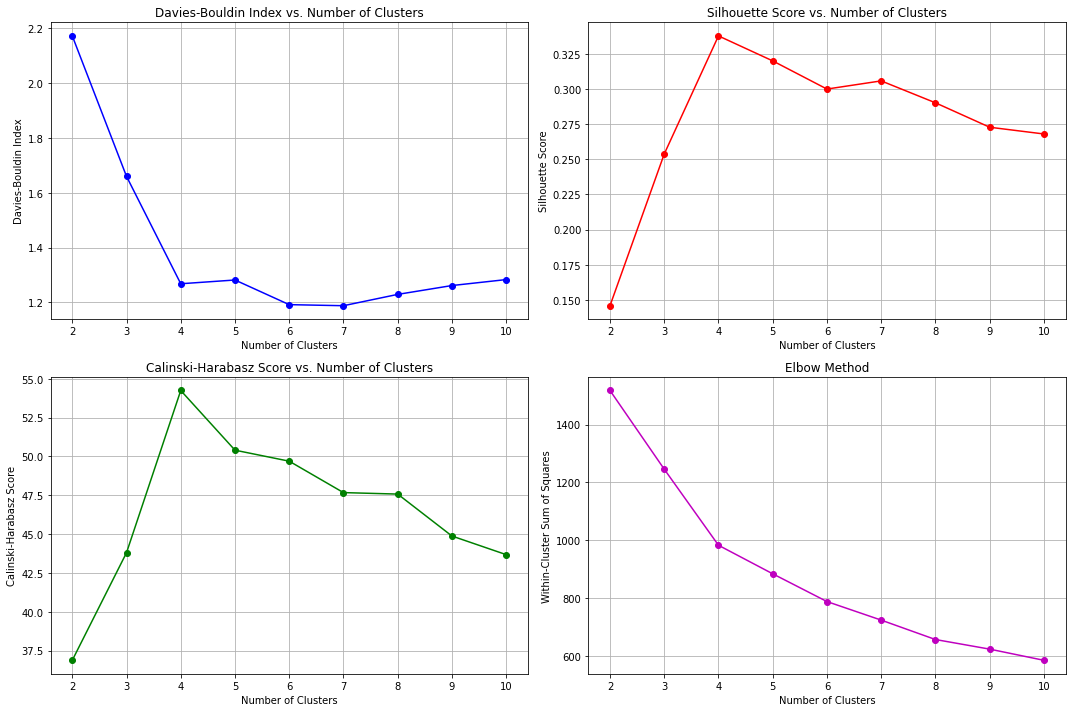

In [70]:
metrics_fig = plot_metrics(results)

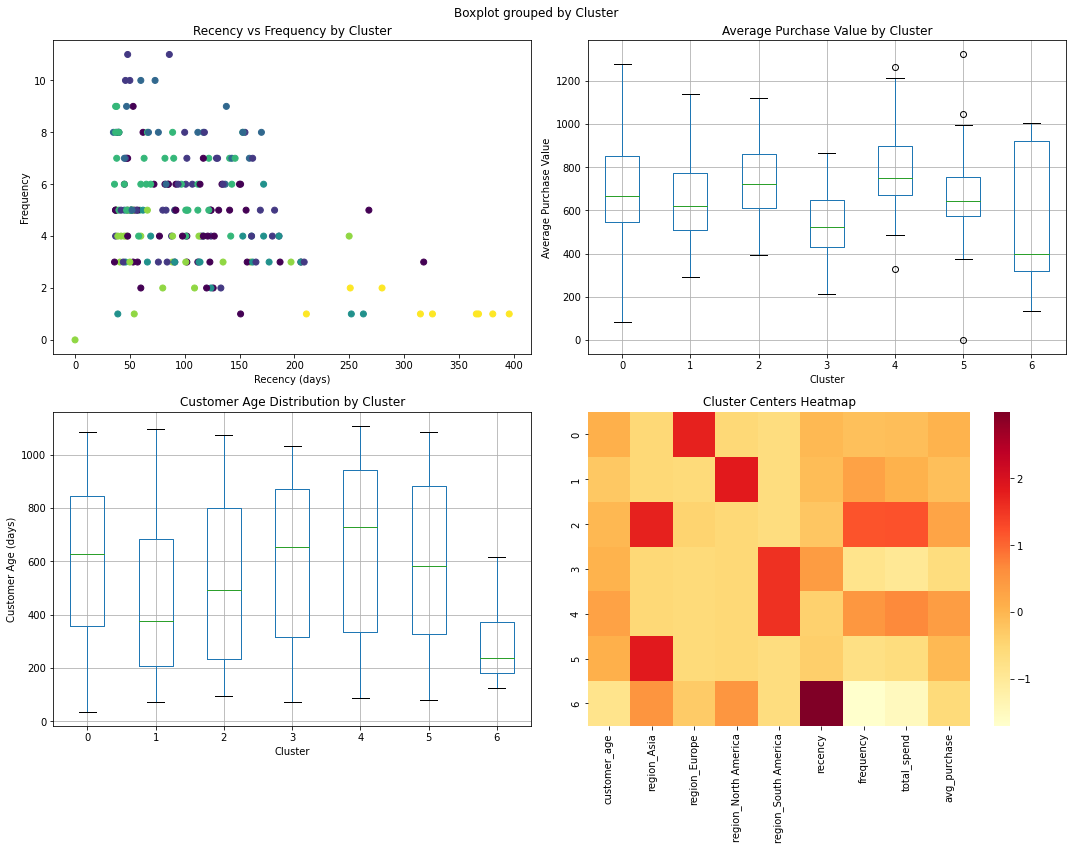

In [71]:
cluster_fig = plot_results(data, best_model['model'], scaled_features, feature_columns, best_model['n_clusters'])